# Fine-tuning InceptionV3 for flowers classification


主要是做练习时候的一个困惑： 

使用已经训练好的 InceptionV3，对新的图片分类问题进行训练，**很容易** 产生过拟合：对训练集，很容易达到100%的准确率，但是对测试集/验证集，准确率不到 50%，并且很难继续提升。 这说明什么，说明确实学习到了图片的特征，但是学习能力太强，产生了过拟合。

google了一下，有些参考：

- https://stackoverflow.com/questions/37605611/would-adding-dropout-help-reduce-overfitting-when-following-tensorflows-transfe

- [Image Retraining](https://www.tensorflow.org/tutorials/image_retraining)

这里按照 Image Retraining实际上也很简单，取了最后一层，加上新的训练层，对另一类图片重新进行训练。


还有一个 keras的官方教程： <https://keras.io/applications/#usage-examples-for-image-classification-models>


1. 准备图片，图片处理，数据集分割，以及提供batch方法
2. 准备keras模型
    1. 设置后 x 层重新训练
    2. 添加新的训练层
    3. 添加评估方法
3. 训练评估模型
4. error analysis


一些问题：

1. tarfile解压缩，在内存中，只能按照某种固定顺序解压文件。
2. 可以先解压到/tmp下面，然后再随机读取图片文件，形成batch，但是这样又会产生IO问题。 再说吧，这个不是主要问题。

## 1. import 和全局参数

In [1]:
import os
import tarfile
import random
import keras
import cv2

import scipy.io

import numpy as np
import tensorflow as tf
import keras.backend as K

from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    return K.get_session()


/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

flowers102_tar_path = "../readonly/week3/102flowers.tgz"
labels_mat_path = '../readonly/week3/imagelabels.mat'

# 图片参数
IMG_SIZE = 250

# 模型参数
LEARNING_RATE = 0.01
TRAINING_STEPS = 4000
EVAL_STEP_INTERVAL = 100
TRAIN_BATCH_SIZE = 100
VALIDATION_BATCH_SIZE = 100
TEST_BATCH_SIZE = -1



## 2. 准备数据集

这里是102flowers数据，包括102种花。

来源： <http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html>

注意：

1. 图片和标签是分开的，还得按顺序一一对应。。
2. 取数据的方式是每次都从 tgz里面解压取。估计用到了缓存，所以第一次比较慢，后面都很快。


准备训练集、验证集和测试集以及标签。以及batch方法

In [3]:
flowers102_tar_path = "../readonly/week3/102flowers.tgz"
labels_mat_path = '../readonly/week3/imagelabels.mat'
tmp_flowers_path = '/tmp/flowers/'

if not os.path.exists(tmp_flowers_path):
    os.makedirs(tmp_flowers_path)

if not os.path.exists(os.path.join(tmp_flowers_path, 'jpg')):
    tarfile.open(flowers102_tar_path, 'r:gz').extractall(tmp_flowers_path)

with tarfile.open(flowers102_tar_path) as f:
    all_files = [m.name for m in f.getmembers() if m.isfile()]

all_labels = scipy.io.loadmat(labels_mat_path)['labels'][0] - 1

def get_image_path(image_file):
    return os.path.join(tmp_flowers_path, image_file)

8189 102


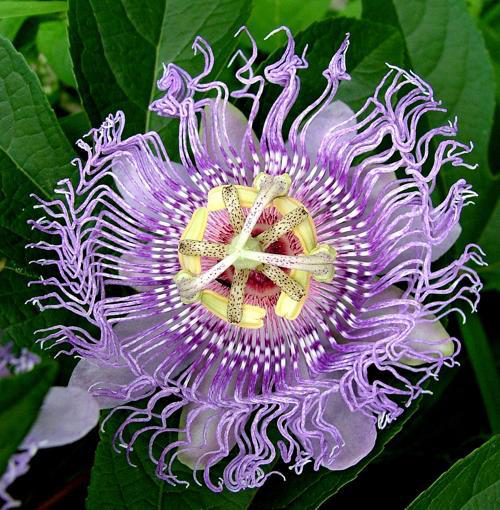

In [4]:
# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(len(all_files), N_CLASSES)

image = Image.open(get_image_path(all_files[0]))
image

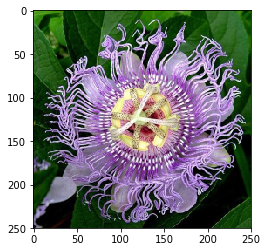

In [5]:


def get_image_data(image_file, crop_and_resize=True, normalize_for_model=True):
    image_path = os.path.join(tmp_flowers_path, image_file)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if crop_and_resize:
        def _cut_slice(a, ca):
            c = a - ca
            c1 = int(c/2)
            return slice(c1, c1+ca)
        h, w, _ = img.shape
        img = img[_cut_slice(h, min(h, w)), _cut_slice(w, min(h, w)), :]
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img
    

img = get_image_data(all_files[0], normalize_for_model=False)
plt.imshow(img)
plt.show()

In [6]:
# split into train/test
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [20]:
def next_batch(files, labels, batch_size):
    while True:
        indexes = np.random.permutation(len(files))
        targets = keras.utils.to_categorical(labels)
        for i in range(0, len(files) - batch_size + 1, batch_size):
            idx = indexes[i: i+batch_size]
            batch_imgs = []
            for i in idx:
                batch_imgs.append(get_image_data(files[i]))
            batch_imgs = np.stack(batch_imgs, axis=0)
            batch_targets = targets[idx, :]
            yield batch_imgs, batch_targets

(100, 250, 250, 3) (100, 102)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


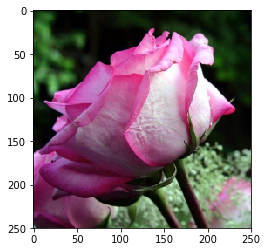

In [21]:
# test training generator
for _ in next_batch(tr_files, tr_labels, TRAIN_BATCH_SIZE):
    print(_[0].shape, _[1].shape)
    print(_[1][0])
    plt.imshow(np.clip(_[0][0] / 2. + 0.5, 0, 1))
    break

# Training

You cannot train such a huge architecture from scratch with such a small dataset.

But using fine-tuning of last layers of pre-trained network you can get a pretty good classifier very quickly.

In [22]:
# remember to clear session if you start building graph from scratch!
s = reset_tf_session()
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)

In [23]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [24]:
model = inception()

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 124, 124, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 124, 124, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [26]:
# how many layers our model has
print(len(model.layers))

313


In [27]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    layer.trainable = False

In [28]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [29]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'flowers.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 10
# model = load_model(model_filename.format(last_finished_epoch))

Training takes **2 hours**. You're aiming for ~0.93 validation accuracy.

In [31]:
# fine tune for 2 epochs (full passes through all training data)
# we make 2*8 epochs, where epoch is 1/8 of our training data to see progress more often
model.fit_generator(
    next_batch(tr_files, tr_labels, 100), 
    steps_per_epoch=len(tr_files) // 100,
    epochs=15,
    validation_data=next_batch(te_files, te_labels, VALIDATION_BATCH_SIZE), 
    validation_steps=len(te_files) // VALIDATION_BATCH_SIZE,
#     callbacks=[keras_utils.TqdmProgressCallback(), 
# #                keras_utils.ModelSaveCallback(model_filename)
#               ],
    verbose=1,
    initial_epoch=last_finished_epoch or 0
)

Epoch 1/15
65/65 [==============================] - 21s 328ms/step - loss: 4.5941 - acc: 0.0311 - val_loss: 4.5668 - val_acc: 0.0344
Epoch 2/15
65/65 [==============================] - 19s 300ms/step - loss: 4.5130 - acc: 0.0346 - val_loss: 4.5445 - val_acc: 0.0300
Epoch 3/15
65/65 [==============================] - 19s 298ms/step - loss: 4.4497 - acc: 0.0394 - val_loss: 4.5403 - val_acc: 0.0300
Epoch 4/15
65/65 [==============================] - 19s 298ms/step - loss: 4.3698 - acc: 0.0455 - val_loss: 4.5248 - val_acc: 0.0331
Epoch 5/15
65/65 [==============================] - 19s 298ms/step - loss: 4.2379 - acc: 0.0646 - val_loss: 4.5482 - val_acc: 0.0294
Epoch 6/15
65/65 [==============================] - 19s 298ms/step - loss: 4.0302 - acc: 0.1026 - val_loss: 4.5986 - val_acc: 0.0256
Epoch 7/15
42/65 [==================>...........] - ETA: 5s - loss: 3.6987 - acc: 0.1960

KeyboardInterrupt: 

In [ ]:
## GRADED PART, DO NOT CHANGE!
# Accuracy on validation set
test_accuracy = model.evaluate_generator(
    train_generator(te_files, te_labels), 
    len(te_files) // BATCH_SIZE // 2
)[1]
grader.set_answer("wuwwC", test_accuracy)
print(test_accuracy)

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

That's it! Congratulations!

What you've done:
- prepared images for the model
- implemented your own batch generator
- fine-tuned the pre-trained model